In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')

def feature_engineering(df):

    df_eng = df.copy()

    df_eng = df_eng.drop(columns=['Id', 'AvgTime'])

    df_eng['VIP'] = df_eng['VIP'].fillna(False).astype(int)
    df_eng['Age'] = df_eng['Age'].fillna(df_eng['Age'].median())
    df_eng[['Food', 'Drinks']] = df_eng[['Food', 'Drinks']].fillna(0)

    df_eng['TotalSpent'] = df_eng['Food'] + df_eng['Drinks']
    df_eng['Has_Spent'] = (df_eng['TotalSpent'] > 0).astype(int)
    df_eng['FoodShare'] = df_eng['Food'] / (df_eng['TotalSpent'] + 0.01)
    
    # --- Vinyl: imputación por PreferedAlbum ---
    # 1) Calcula la moda de Vinyl por álbum usando solo los NO-NaN
    vinyl_mode_by_album = (
        df_eng.dropna(subset=['Vinyl'])
            .groupby('PreferedAlbum')['Vinyl']
            .agg(lambda x: x.mode().iloc[0])
    )

    # 2) Rellena los NaN de Vinyl con la moda del álbum correspondiente
    mask = df_eng['Vinyl'].isna()
    df_eng.loc[mask, 'Vinyl'] = df_eng.loc[mask, 'PreferedAlbum'].map(vinyl_mode_by_album)

    # 3) Si aún quedan NaN (álbum no visto o sin moda), rellena con la moda global
    global_mode_vinyl = df_eng['Vinyl'].mode(dropna=True)[0]
    df_eng['Vinyl'] = df_eng['Vinyl'].fillna(global_mode_vinyl).astype(int)

    modePreferedAlbum = df_eng['PreferedAlbum'].mode()[0]
    df_eng['PreferedAlbum'] = df_eng['PreferedAlbum'].fillna(modePreferedAlbum)
    
    modeConcert = df_eng['Concert'].mode()[0]
    df_eng['Concert'] = df_eng['Concert'].fillna(modeConcert)

    #Tickets
    # Tickets
    ticket = (
        df_eng['TicketInfo']
        .fillna('Unknown/Unknown/Unknown')
        .str.split('/', expand=True)
    )

    df_eng['Ticket_Zone'] = ticket[0]
    df_eng['Ticket_Number'] = pd.to_numeric(ticket[1], errors='coerce')
    df_eng['Ticket_Type'] = ticket[2]
    # Ticket_Number: crea flag + imputa
    df_eng['Ticket_Number_Missing'] = df_eng['Ticket_Number'].isna().astype(int)
    df_eng['Ticket_Number'] = df_eng['Ticket_Number'].fillna(df_eng['Ticket_Number'].median())
    df_eng = df_eng.drop(columns=['TicketInfo'])

    scale_cols = ['Age', 'Food', 'Drinks', 'TotalSpent', 'Ticket_Number']

    for col in scale_cols:
        mean = df_eng[col].mean()
        std = df_eng[col].std()
        df_eng[col] = (df_eng[col] - mean) / std


    return df_eng

train_df = feature_engineering(train)
test_df = feature_engineering(test)

C:\Users\Admin\AppData\Local\Temp\ipykernel_4044\1262061679.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_eng['VIP'] = df_eng['VIP'].fillna(False).astype(int)
C:\Users\Admin\AppData\Local\Temp\ipykernel_4044\1262061679.py:32: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_eng['Vinyl'] = df_eng['Vinyl'].fillna(global_mode_vinyl).astype(int)
C:\Users\Admin\AppData\Local\Temp\ipykernel_4044\1262061679.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.in

In [109]:
train_df.info()
y = train_df['FreePass']
train_df = train_df.drop(columns=['FreePass'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10116 entries, 0 to 10115
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PreferedAlbum          10116 non-null  object 
 1   Vinyl                  10116 non-null  int64  
 2   Opinion                8613 non-null   object 
 3   Concert                10116 non-null  object 
 4   Age                    10116 non-null  float64
 5   VIP                    10116 non-null  int64  
 6   Food                   10116 non-null  float64
 7   Drinks                 10116 non-null  float64
 8   FreePass               10116 non-null  bool   
 9   TotalSpent             10116 non-null  float64
 10  Has_Spent              10116 non-null  int64  
 11  FoodShare              10116 non-null  float64
 12  Ticket_Zone            10116 non-null  object 
 13  Ticket_Number          10116 non-null  float64
 14  Ticket_Type            10116 non-null  object 
 15  Ti

In [110]:
num_cols = ['Age', 'Food', 'Drinks', 'TotalSpent', 'Ticket_Number', 'FoodShare']
bool_cols = ['VIP', 'Has_Spent', 'Vinyl']
cat_cols = ['PreferedAlbum', 'Concert', 'Ticket_Zone', 'Ticket_Type']

for df in [train_df, test_df]:
    df['Opinion'] = (
        df['Opinion']
        .fillna('')
        .astype(str)
        .str.lower()
        .str.replace(r'[^a-z0-9\s]', ' ', regex=True)
        .str.replace(r'\s+', ' ', regex=True)
        .str.strip()
    )


In [111]:
text_train = train_df['Opinion']
text_test  = test_df['Opinion']

train_df_no_text = train_df.drop(columns=['Opinion'])
test_df_no_text  = test_df.drop(columns=['Opinion'])

train_X = pd.get_dummies(train_df_no_text, columns=cat_cols, dummy_na=True)
test_X  = pd.get_dummies(test_df_no_text,  columns=cat_cols, dummy_na=True)

train_X, test_X = train_X.align(test_X, join='left', axis=1, fill_value=0)

In [112]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# vectorizer = TfidfVectorizer(
#     min_df=2,
#     max_df=0.9,
#     ngram_range=(1,2),
#     max_features=30000
# )

vectorizer = CountVectorizer(
    min_df=2,
    stop_words='english',
    strip_accents='unicode'
)

Xtr_text = vectorizer.fit_transform(text_train)
Xte_text = vectorizer.transform(text_test)

In [113]:
train_X_notxt = train_X.drop(columns=['Opinion'], errors='ignore')
test_X_notxt  = test_X.drop(columns=['Opinion'], errors='ignore')

In [114]:
from scipy.sparse import hstack, csr_matrix

Xtr_other = csr_matrix(train_X_notxt.to_numpy(dtype=float))
Xte_other = csr_matrix(test_X_notxt.to_numpy(dtype=float))


Xtr_final = hstack([Xtr_other, Xtr_text])
Xte_final = hstack([Xte_other, Xte_text])


In [128]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# PreferedAlbum_nan                 0.000000
# VIP                               0.000000
# Ticket_Zone_nan                   0.000000
# Ticket_Zone_RT                    0.000000
# Ticket_Zone_RB                    0.000000
# Concert_nan                       0.000000
# Ticket_Type_nan                   0.000000
# Ticket_Zone_PB                   -0.000033
# Concert_SF14-7pm                 -0.000297
# Ticket_Zone_A                    -0.000593

drop_cols = ['VIP','Ticket_Zone_A','Ticket_Zone_PB','Ticket_Zone_PB', 'PreferedAlbum_nan','Concert_SF14-7pm', 'Concert_nan', 'Ticket_Zone_RT', 'Ticket_Zone_nan', 'Ticket_Type_nan']

# drop_cols = ['PreferedAlbum_nan', 'Concert_nan', 'Ticket_Zone_RT', 'Ticket_Zone_nan', 'Ticket_Type_nan']
# train_X_notxt = train_X_notxt.drop(columns=drop_cols, errors='ignore')
# test_X_notxt  = test_X_notxt.drop(columns=drop_cols, errors='ignore')

# eliminate_cols = ['Ticket_Zone_PB', 'Ticket_Zone_Unknown', 'Ticket_Number_Missing',
#                   'Ticket_Type_Unknown', 'Ticket_Zone_A', 'Concert_SF14-7pm', 'Concert_FL16-7pm']
# train_X_notxt = train_X_notxt.drop(columns=eliminate_cols, errors='ignore')
# test_X_notxt  = test_X_notxt.drop(columns=eliminate_cols, errors='ignore')

# train_X_notxt['HighFoodShare'] = (train_X_notxt['FoodShare'] > 0.7).astype(int)
# test_X_notxt['HighFoodShare'] = (test_X_notxt['FoodShare'] > 0.7).astype(int)

# train_X_notxt['HighFoodShare_LowSpent'] = (
#     (train_X_notxt['FoodShare'] > 0.7) & (train_X_notxt['TotalSpent'] < train_X_notxt['TotalSpent'].median())
# ).astype(int)

# test_X_notxt['HighFoodShare_LowSpent'] = (
#     (test_X_notxt['FoodShare'] > 0.7) & (test_X_notxt['TotalSpent'] < test_X_notxt['TotalSpent'].median())
# ).astype(int)


train_X_notxt['HighFoodShare_LowSpent'] = (
    (train_X_notxt['FoodShare'] > 0.7) &
    (train_X_notxt['TotalSpent'] < train_X_notxt['TotalSpent'].median())
).astype(int)

test_X_notxt['HighFoodShare_LowSpent'] = (
    (test_X_notxt['FoodShare'] > 0.7) &
    (test_X_notxt['TotalSpent'] < train_X_notxt['TotalSpent'].median())
).astype(int)


X_train_notxt, X_val_notxt, y_train, y_val = train_test_split(
    train_X_notxt,
    y,
    test_size=0.30,
    random_state=42,
)

X_train, X_val, y_train, y_val = train_test_split(
    Xtr_final,
    y,
    test_size=0.30,
    random_state=42,
)   

from sklearn.linear_model import LogisticRegression

clfLog = LogisticRegression(
    max_iter=3000,
    C=2,
    solver='liblinear',
)

clfSLV = LinearSVC(
    max_iter=3000,
    C=1,
)

# clfRFold = RandomForestClassifier(
#     n_estimators=500,
#     max_depth=10,
#     random_state=42,
#     class_weight='balanced'
# )

# Best params: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 5, 
#               'max_features': 0.3, 'max_depth': 8, 'class_weight': None, 'bootstrap': True}

# Best params: {'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 1, 
# 'max_features': 0.3, 'max_depth': 10, 'class_weight': 'balanced', 'bootstrap': True}


#Best params: {'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 2, 
# 'max_features': 0.3, 'max_depth': 8, 'class_weight': None, 'bootstrap': True}

clfRF = RandomForestClassifier(
    n_estimators=800,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features=0.3,
    max_depth=8,
    random_state=42,
    class_weight=None,
    bootstrap=True
)

clfDT = DecisionTreeClassifier(
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)


clfLog.fit(X_train, y_train)
clfSLV.fit(X_train, y_train)
clfRF.fit(X_train_notxt, y_train)
clfDT.fit(X_train, y_train)


from sklearn.metrics import accuracy_score, classification_report

y_pred_Log = clfLog.predict(X_val)
y_pred_SLV = clfSLV.predict(X_val)
y_pred_RF  = clfRF.predict(X_val_notxt)
y_pred_DT  = clfDT.predict(X_val)

print("Accuracy Log (YES Opinion):", accuracy_score(y_val, y_pred_Log))
# print(classification_report(y_val, y_pred_Log))

print("Accuracy SLV (YES Opinion):", accuracy_score(y_val, y_pred_SLV))
# print(classification_report(y_val, y_pred_SLV))

print("Accuracy RF (NO Opinion):", accuracy_score(y_val, y_pred_RF))
# print(classification_report(y_val, y_pred_RF))

print("Accuracy DT (YES Opinion):", accuracy_score(y_val, y_pred_DT))
# print(classification_report(y_val, y_pred_DT))


Accuracy Log (YES Opinion): 0.8079077429983526
Accuracy SLV (YES Opinion): 0.8065897858319605
Accuracy RF (NO Opinion): 0.8164744645799011
Accuracy DT (YES Opinion): 0.8092257001647446


In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold


X_train_notxt, X_val_notxt, y_train, y_val = train_test_split(
    train_X_notxt,
    y,
    test_size=0.30,
    random_state=42,
)

clfRF = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)

# Define the parameters to try during Randomized Search
param_dist = {
    "n_estimators": [300, 500, 800, 1200],
    "max_depth": [None, 8, 10, 12, 16, 20],
    "min_samples_leaf": [1, 2, 5, 10, 20],
    "min_samples_split": [2, 5, 10, 20],
    "max_features": ["sqrt", "log2", 0.3, 0.5, 0.8],
    "bootstrap": [True],                 # RF típico
    "class_weight": [None, "balanced"]   # a veces ayuda
}

CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Divides the data into 5 folds, preserving class distribution, shuffling for randomness.
# Folding means that in each iteration, 4 folds are used for training and 1 for validation.


# It checks 50 different combinations of the above parameters
# The Kfold divides the data into 5 parts, training on 4 and validating on 1 each time. 
# For each combination of parameters it finds 5 values of the accuracy and then averages them to get a final score.
search = RandomizedSearchCV(
    estimator=clfRF,
    param_distributions=param_dist,
    n_iter=50, # number of different combinations to try
    scoring='accuracy',
    cv = CV,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train_notxt, y_train)

print("Best CV accuracy:", search.best_score_)
print("Best params:", search.best_params_)
best_rf = search.best_estimator_

results = pd.DataFrame(search.cv_results_)
cols = ["mean_test_score", "std_test_score", "rank_test_score", "params"]
results[cols].sort_values("rank_test_score").head(10)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best CV accuracy: 0.8207880299351299
Best params: {'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.3, 'max_depth': 8, 'class_weight': None, 'bootstrap': True}


,mean_test_score,std_test_score,rank_test_score,params
37,0.820788,0.003413,1,"{'n_estimators': 800, 'min_samples_split': 10,..."
5,0.820223,0.003742,2,"{'n_estimators': 500, 'min_samples_split': 2, ..."
11,0.819659,0.006948,3,"{'n_estimators': 800, 'min_samples_split': 10,..."
17,0.819659,0.006022,4,"{'n_estimators': 300, 'min_samples_split': 20,..."
27,0.819236,0.006606,5,"{'n_estimators': 1200, 'min_samples_split': 5,..."
7,0.819235,0.005513,6,"{'n_estimators': 1200, 'min_samples_split': 10..."
2,0.819094,0.006681,7,"{'n_estimators': 300, 'min_samples_split': 10,..."
0,0.819093,0.003496,8,"{'n_estimators': 300, 'min_samples_split': 5, ..."
41,0.818812,0.004832,9,"{'n_estimators': 1200, 'min_samples_split': 20..."
42,0.818812,0.003874,10,"{'n_estimators': 800, 'min_samples_split': 10,..."


In [117]:
import pandas as pd

best_rf = RandomForestClassifier(
    n_estimators=800,
    min_samples_split=20,
    min_samples_leaf=5,
    max_features=0.3,
    max_depth=12,
    random_state=42,
    class_weight=None,
    bootstrap=True
)

best_rf.fit(X_train_notxt, y_train)

importances = pd.Series(
    best_rf.feature_importances_,
    index=X_train_notxt.columns
).sort_values(ascending=False)

importances.head(100)

TotalSpent                        0.189558
Has_Spent                         0.147587
FoodShare                         0.136720
Vinyl                             0.098502
Food                              0.090943
Drinks                            0.088387
Ticket_Number                     0.066370
Age                               0.036594
PreferedAlbum_Kind of Blue        0.024767
PreferedAlbum_Head Hunters        0.022288
PreferedAlbum_Bright Size Life    0.016326
Ticket_Zone_CB                    0.013792
Ticket_Zone_B                     0.011832
Ticket_Type_XL                    0.011567
Ticket_Type_N                     0.010534
Ticket_Zone_LB                    0.008476
Concert_NYC12-5pm                 0.006173
Ticket_Zone_LT                    0.005693
Concert_FL16-7pm                  0.005069
Ticket_Zone_A                     0.003528
Concert_SF14-7pm                  0.002019
Ticket_Zone_PB                    0.001177
Ticket_Zone_RB                    0.000723
VIP        

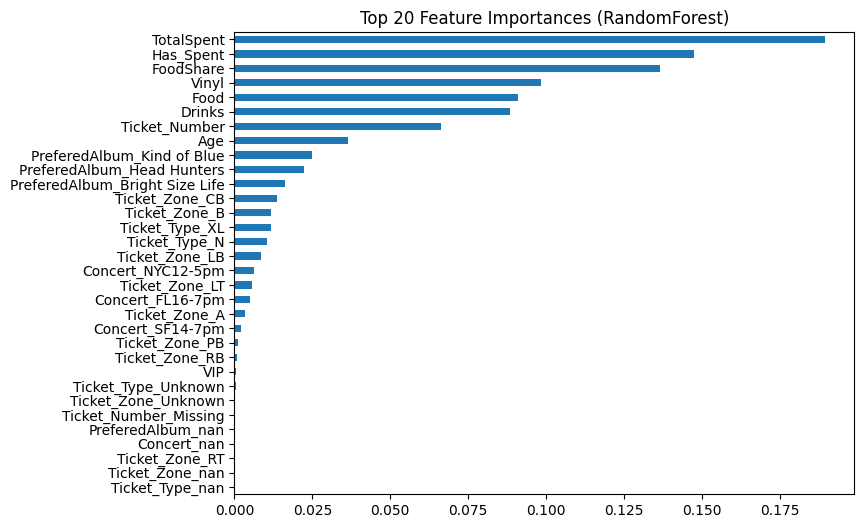

In [118]:
import matplotlib.pyplot as plt

importances.head(100).plot(kind='barh', figsize=(8,6))
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances (RandomForest)")
plt.show()


In [119]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    best_rf,
    X_val_notxt,      # usa validación, no train
    y_val,
    n_repeats=10,
    random_state=42,
    scoring='accuracy'
)

perm_importances = pd.Series(
    perm.importances_mean,
    index=X_val_notxt.columns
).sort_values(ascending=False)



In [ ]:
perm_importances.head(100)

FoodShare                         0.039703
Vinyl                             0.023690
TotalSpent                        0.014761
Food                              0.013871
PreferedAlbum_Bright Size Life    0.013147
Ticket_Number                     0.011928
PreferedAlbum_Kind of Blue        0.005931
Has_Spent                         0.005535
Drinks                            0.005140
Ticket_Zone_CB                    0.004283
Ticket_Type_XL                    0.003295
PreferedAlbum_Head Hunters        0.003295
Ticket_Zone_B                     0.003130
Ticket_Zone_LB                    0.002570
Ticket_Type_N                     0.002405
Age                               0.002306
Concert_NYC12-5pm                 0.001120
Ticket_Zone_LT                    0.000890
Ticket_Type_Unknown               0.000329
Ticket_Number_Missing             0.000329
Ticket_Zone_Unknown               0.000329
Concert_FL16-7pm                  0.000198
PreferedAlbum_nan                 0.000000
VIP        

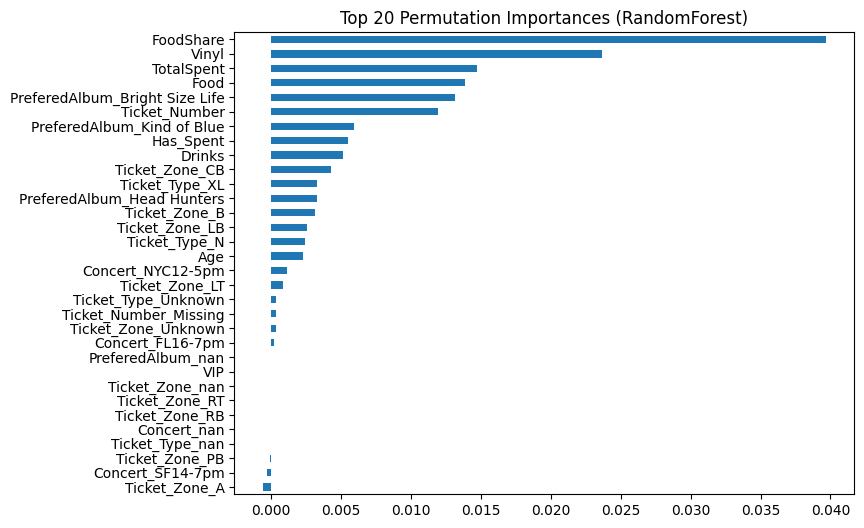

In [120]:
perm_importances.head(100).plot(kind='barh', figsize=(8,6))
plt.gca().invert_yaxis()
plt.title("Top 20 Permutation Importances (RandomForest)")
plt.show()

    -   Top 20 Features Importances: cuánto reduce la impureza (Gini) una variable cuando se usa para hacer splits en los árboles. Cada vez que el árbol usa una variable para dividir y esa división gana pureza, la variable gana puntos. Al final se promedia sobre todos los árboles. Muestra las variables que le gusta usar al modelo para construir los árboles.

    -   Top 20 Permutation Importances: si se rompe una variable, cuanto emperoa la accuracy en dotos no vistos?. Coges validación, desordenas una columna, vuelves a predecir, mides cuanto cambia el accuracy respecto a la original. Se repite varias veces y se promedia. Esto te dice que variables son necesarias. Entonces si es negativa la importancia, indica que la accuracy mejora si se modifica esa columna, entonces esa feature esta perjudicando a la generalización.

c:\Users\Admin\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


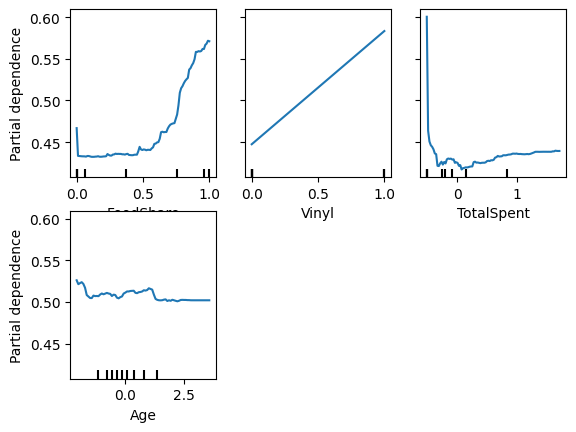

In [121]:
from sklearn.inspection import PartialDependenceDisplay

features = ['FoodShare', 'Vinyl', 'TotalSpent', 'Age']
PartialDependenceDisplay.from_estimator(
    best_rf, X_val_notxt, features
)


    - Partial Dependen Plots (PDP): como cambia la predicción media del modelo cuando esa variable cambia y el resto se mantiene igual. Eje X es el valor de la feature y la Y es la tendencia de predecir la clase True. Las rayitas negras son donde hay datos reaeles:
      - FoodShare: plana y luego sube cuando FoodShare es alto. Cuanto mas alto es FoodShare más probabilidad de decir True. 
      - Vinyl: aumenta la prediccion de True tener Vinyl = 1.
      - TotalSpent: rarete, a partir de cierto gasto ya no cambia tanto la predicción.
      - Age: la edad influye poco en la predicciónd e True.

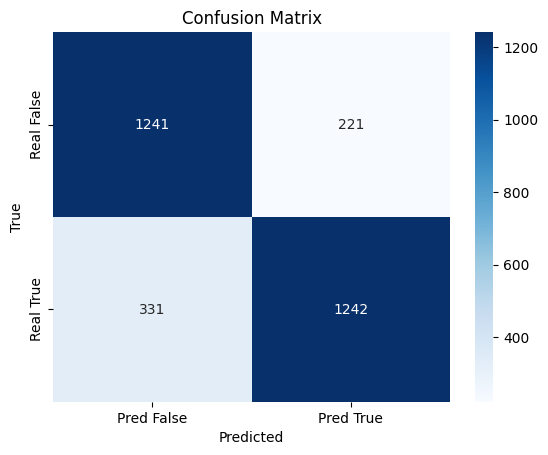

In [122]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_pred_RF)
cm
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Pred False", "Pred True"],
    yticklabels=["Real False", "Real True"]
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


    - Confusion Matrix
      - TN = Era False y dijo False (BIEN)
      - FP = Era False y dijo True (MAL)
      - FN = Era True y dijo False (MAL)
      - TP = Era True y dijo True (BIEN)

In [123]:
errors = X_val_notxt.copy()
errors['y_true'] = y_val
errors['y_pred'] = best_rf.predict(X_val_notxt)

errors['error_type'] = 'Correct'
errors.loc[(errors.y_true == 0) & (errors.y_pred == 1), 'error_type'] = 'False Positive'
errors.loc[(errors.y_true == 1) & (errors.y_pred == 0), 'error_type'] = 'False Negative'

fp = errors[errors.error_type == 'False Positive']
fn = errors[errors.error_type == 'False Negative']
correct = errors[errors.error_type == 'Correct']

In [124]:
cols = ['FoodShare', 'TotalSpent', 'Ticket_Number', 'Age']

errors.groupby('error_type')[cols].mean()

#Correct = Casos normales
# FN = Falsos negativos (Era false, pero predijo true)
# FP = Falsos positivos (Era true, pero predijo false)

,FoodShare,TotalSpent,Ticket_Number,Age
error_type,,,,
Correct,0.320596,0.028558,-0.033977,0.009122
False Negative,0.726448,0.023736,0.023892,0.075104
False Positive,0.325540,-0.261897,0.187973,-0.255336


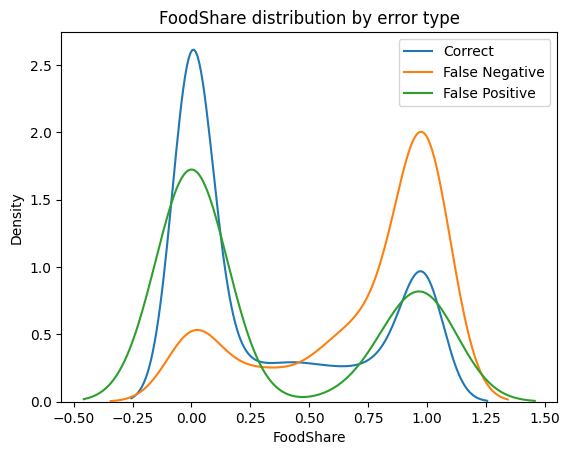

In [125]:

import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(correct['FoodShare'], label='Correct')
sns.kdeplot(fn['FoodShare'], label='False Negative')
sns.kdeplot(fp['FoodShare'], label='False Positive')
plt.legend()
plt.title('FoodShare distribution by error type')
plt.show()


    - Tabla + Gráfica:
      - Tabla: te dice para cada tipo de resultado el valor medio de la columna. Lo que hacemos es: coger el test de validacion, miramos cuando hay correct, FP y FN. Para cada tipo de resultado se calcula el promedio de esa Feature.
        - FoodShare: 
          - Las filas bien clasificadas tienen FoodShare bajo-medio
          - Las filas FN tienen valor alto 
          - Las filas FP se parecen mucho a los correctos
        - TotalSpent:
          - Filas bien gasto bajo
          - Filas FN gasto bajo
          - Filas FP gasto bajo-medio
        - Ticket Number y Age
      - Gráfica: eje X FoodShare e Y es la densidad (valores más frecuentes) y cada curva es un tipo de predicción. Te dicen la tendencia completa de cada valor de FoodShare a tener un resultado concreto. Y la tabla te da la media

Viendo estas gráficas, podemos decir que el modelo se basa sobretodo en el gasto. Y FoodShare es importante. Los errores se concentrar en FoodShare alto:

    - Podriamos probar a hacer alguna Feature nueva.
    - Quedarnos como estamos XD, esta bien. Estaremos cerca del limite
    - Intentar meter la Opinion en el RandomForest, que ahora mismo no esta metido.
  
- De la tabla anterior vemos que los FN tienen un FoodShare alto y un gasto bajo. El FoodShare puede darse cuando Food es grande y TotalSpent bajo (respecto a Food). El FoodShare alto empuja a True y el TotalSpent empuja a False, señales se contradice y el modelo duda. El FoodShare aumenta la probabilidad de True cuando aumenta su valor. El TotalSpent bajo esta asociado a menor probabilidad de True (esto del PDP, las cuatro graficas pequeñas de antes).

De la grafica justo anterior se ve claramente que hay muchos FN con FoodShare alto y eso corresponde con gasto bajo. 

In [129]:
clfRF.fit(train_X_notxt, y)
y_test_pred = clfRF.predict(test_X_notxt)
submission = pd.DataFrame({
    'Id': test['Id'],
    'FreePass': y_test_pred
})
submission.to_csv('submission.csv', index=False)